<a href="https://colab.research.google.com/github/sean-otoole/HODD/blob/main/PDTx_pipeline/PDTx_03_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# downgrade numpy
!pip uninstall numpy -y
!pip install numpy==1.26.4

# fixes a compatibility issue with the PrecollatorForGeneAndCellClassification class
!pip install --upgrade transformers==4.41
!pip install peft==0.10.0

# Uninstall and reinstall scipy and scikit-learn to ensure compatibility with the specified numpy version
!pip uninstall scipy -y
!pip uninstall scikit-learn -y
!pip install scipy
!pip install scikit-learn
!pip install wandb

In [2]:
!rm /content/drive/MyDrive/HODD/geneformer_modified/.git/hooks/post-checkout

rm: cannot remove '/content/drive/MyDrive/HODD/geneformer_modified/.git/hooks/post-checkout': No such file or directory


Please note, it is necceesary to restart the session especially after the package downgrades for this code to work properly. So, simply restart after running the previous cell.

In [ ]:
# mount the drive

from google.colab import drive
import os

# Mount Google Drive to access files
drive.mount('/content/drive')

# Change the working directory to the project folder in Google Drive
os.chdir("/content/drive/MyDrive/HODD/")

## cloning the modified verison, to incorporate Weighted cross-entropy loss
!git lfs install
!git clone https://huggingface.co/sotoole/geneformer_modified
%cd geneformer_modified

# Install Geneformer modified locally
!pip install .

# Install required libraries without outputting installation logs
!pip install anndata scanpy tdigest datasets

# Import necessary modules and libraries
import numpy
import transformers
import sklearn
import pickle
import sklearn

print(numpy.__version__)

In [1]:
import pickle

# bulding the mapping dictionary

# Define class mapping: 0 = Parkinson's, 1 = Normal
new_id_class_dict = {
    0: "normal",
    1: "Parkinson_disease",
}

# Overwrite the existing mapping file
file_path = '/content/drive/MyDrive/HODD/datasets/park_classifier_id_class_dict.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(new_id_class_dict, f)

print("Mapping file saved.")

# Reload and print to confirm
with open(file_path, 'rb') as f:
    loaded_dict = pickle.load(f)

print("Loaded class mapping:")
for k, v in loaded_dict.items():
    print(f"{k}: {v}")

Mapping file saved.
Loaded class mapping:
0: normal
1: Parkinson_disease


In [2]:
import datetime

current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"

output_prefix = "parkinsons"
output_dir = f"/content/drive/MyDrive/HODD/models/{datestamp}"

!mkdir $output_dir

print(output_dir)

park_data_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_tokenized.dataset/'
geneformer_directory = '/content/drive/MyDrive/HODD/Geneformer/gf-12L-95M-i4096'

/content/drive/MyDrive/HODD/models/250609192124


##Prepare the data

In [3]:
from datasets import load_dataset, load_from_disk, ClassLabel, concatenate_datasets
import numpy as np
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# Load the dataset
park_data_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_tokenized.dataset/'
park_data = load_from_disk(park_data_path)

# Add ID column for tracking
park_data = park_data.add_column("id", list(range(len(park_data))))

# Define classes explicitly
classes = ["normal", "Parkinson_disease"]

# Convert label to ClassLabel type
park_data = park_data.cast_column("disease_state", ClassLabel(names=classes))
park_data = park_data.rename_column("disease_state", "label")  # must be named "label" for classifier

# Split into train/eval
split_data = park_data.train_test_split(test_size=0.2, seed=42, stratify_by_column="label")
train_data = split_data["train"]
eval_data = split_data["test"]

# Class distribution in original training data
original_counts = Counter(train_data["label"])
print("Original class distribution:", original_counts)

# ===  COMPUTE CLASS WEIGHTS ===
y_train = train_data["label"]
unique_labels = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=unique_labels, y=y_train)
class_weights_list = weights.tolist()
print("Computed class weights:", class_weights_list)

# === NO DOWNSAMPLING — keep full training data ===

# Prepare merged dataset for later validation
park_data_with_id_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_with_id_tokenized.dataset/'
park_data = concatenate_datasets([train_data, eval_data])
park_data.save_to_disk(park_data_with_id_path)

print(len(park_data))
print(len(train_data))
print(len(eval_data))

# Prepare ID dictionary
train_ids = train_data["id"]
eval_ids = eval_data["id"]

train_valid_id_split_dict = {
    "attr_key": "id",
    "train": train_ids,
    "eval": eval_ids
}

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Casting the dataset:   0%|          | 0/13533 [00:00<?, ? examples/s]

Original class distribution: Counter({0: 9269, 1: 1557})
Computed class weights: [0.5839896428956738, 3.4765574823378294]


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Saving the dataset (0/1 shards):   0%|          | 0/13533 [00:00<?, ? examples/s]

13533
10826
2707


##Fine-tune the model for cell state classification

In [4]:
from geneformer import Classifier
from transformers import TrainingArguments

training_args = {
    "num_train_epochs": 1,
    "learning_rate": 5e-6,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 500,
    "weight_decay":0.25, #was 0.01
    "per_device_train_batch_size": 32,
    "seed": 73,
    "class_weights_list":class_weights_list
}

cc = Classifier(
    classifier="cell",
    cell_state_dict={"state_key": "disease_state", "states": "all"},
    training_args=training_args,  # pass as dict, not object
    max_ncells=None,
    freeze_layers=2,
    num_crossval_splits=1,
    forward_batch_size=64,   #dropped from 32
    nproc=16
)

# The print statement should now work as expected if the value was correctly passed
print(cc.training_args["num_train_epochs"])

print(cc.training_args["class_weights_list"])

1
[0.5839896428956738, 3.4765574823378294]


In [5]:
import os
import torch
torch.cuda.empty_cache()

os.environ["WANDB_DISABLED"] = "true"

# fine tune the model
all_metrics = cc.validate(model_directory=geneformer_directory,
                          prepared_input_data_file = park_data_with_id_path,
                          id_class_dict_file= '/content/drive/MyDrive/HODD/datasets/park_classifier_id_class_dict.pkl',
                          output_directory=output_dir,
                          output_prefix=output_prefix,
                          split_id_dict=train_valid_id_split_dict)

  0%|          | 0/1 [00:00<?, ?it/s]

****** Validation split: 1/1 ******



/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/HODD/Geneformer/gf-12L-95M-i4096 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLE

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.579800,0.511098,0.819727,0.736556


[INFO] Cross entropy class weights: [0.5839896 3.4765575]


  0%|          | 0/43 [00:00<?, ?it/s]

In [6]:
all_metrics

{'conf_matrix':                    normal  Parkinson_disease
 normal             1870.0              448.0
 Parkinson_disease    40.0              349.0,
 'macro_f1': [0.7365559404021371],
 'acc': [0.819726634650905],
 'all_roc_metrics': {'mean_tpr': array([0.        , 0.47557841, 0.59897172, 0.6529563 , 0.70951157,
         0.75064267, 0.78920308, 0.81233933, 0.8251928 , 0.83290488,
         0.84575835, 0.85861183, 0.86632391, 0.8714653 , 0.87660668,
         0.88688946, 0.89203085, 0.89460154, 0.89717224, 0.89717224,
         0.90488432, 0.9125964 , 0.91773779, 0.92287918, 0.92287918,
         0.92802057, 0.92802057, 0.92802057, 0.93059126, 0.93316195,
         0.94858612, 0.95115681, 0.9562982 , 0.9562982 , 0.9562982 ,
         0.96143959, 0.96401028, 0.96401028, 0.96915167, 0.96915167,
         0.97172237, 0.97172237, 0.97172237, 0.97172237, 0.97429306,
         0.97429306, 0.97429306, 0.97686375, 0.97686375, 0.97686375,
         0.97686375, 0.97943445, 0.98457584, 0.98457584, 0.98

##Evaluate the model

In [7]:
#add ids to the test data

#load the test data
park_data_test_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_test_tokenized.dataset/'
park_data_test = load_from_disk(park_data_test_path)

# Add an 'id' column that stores the original index
park_data_test = park_data_test.add_column("id", list(range(len(park_data_test))))

# Explicit class ordering: 0 = Normal, 1 = Parkinson's,
classes = ["normal","Parkinson_disease"]

# make the disease state column a classlabel
park_data_test = park_data_test.cast_column("disease_state", ClassLabel(names=classes))  #convert the disease state numeric column to a class label

#rename the disease_state column as label

park_data_test = park_data_test.rename_column("disease_state", "label")

# save it back to disk

park_data_test_with_id_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_test_labeled_tokenized.dataset/'

park_data_test.save_to_disk(park_data_test_with_id_path)

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Casting the dataset:   0%|          | 0/3561 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3561 [00:00<?, ? examples/s]

In [8]:
#saved previous model locations due to gpu memory issues

current_dict = '/content/drive/MyDrive/HODD/datasets/park_classifier_id_class_dict.pkl'
test_data_file = park_data_test_with_id_path
output_prefix = "parkinsons"

In [9]:
from geneformer import Classifier

cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease_state", "states": "all"},
                forward_batch_size=36,
                nproc=16)

In [10]:
all_metrics_test = cc.evaluate_saved_model(
        model_directory=f"{output_dir}/{datestamp_min}_geneformer_cellClassifier_{output_prefix}/ksplit1/",
        id_class_dict_file=current_dict,
        test_data_file=test_data_file,
        output_directory=output_dir,
        output_prefix=output_prefix,
    )

  0%|          | 0/99 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

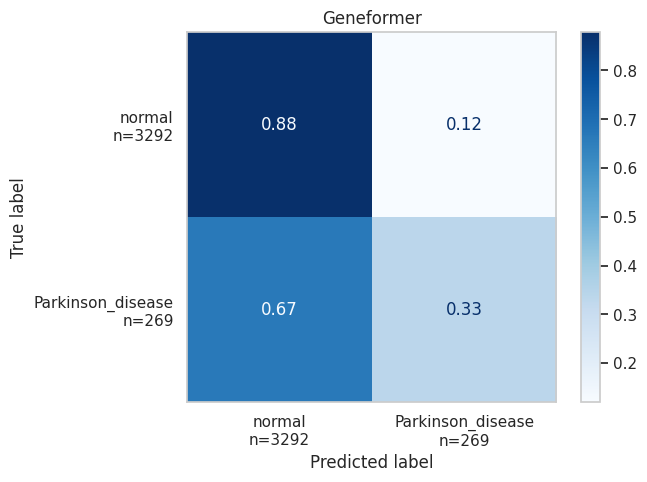

In [11]:
cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory=output_dir,
        output_prefix=output_prefix,
)

<Figure size 1500x1500 with 0 Axes>

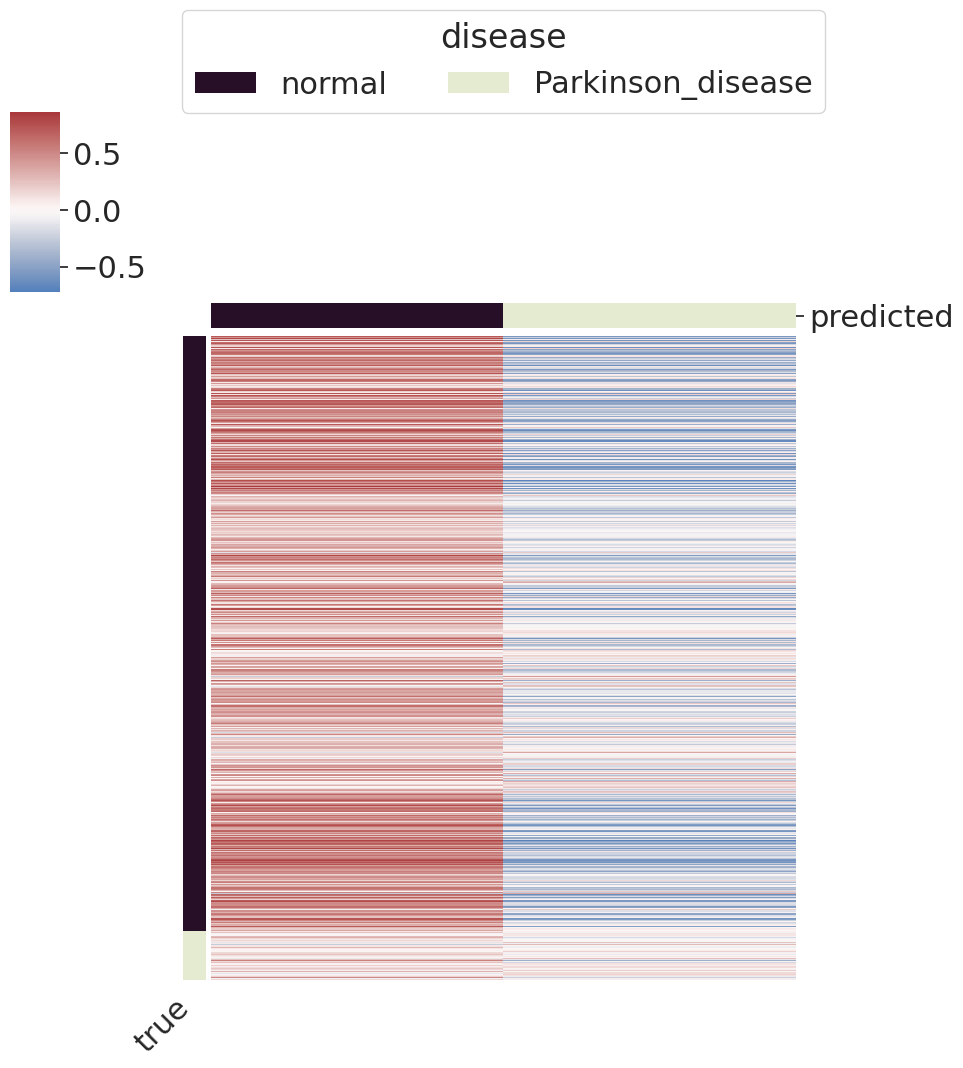

In [12]:
cc.plot_predictions(
    predictions_file=f"{output_dir}/{output_prefix}_pred_dict.pkl",
    id_class_dict_file=current_dict,
    title="disease",
    output_directory=output_dir,
    output_prefix=output_prefix,
)